<a href="https://colab.research.google.com/github/JitheshPavan/ML_Models/blob/main/lenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part-1

In [ ]:
import torch.nn as nn
import torch
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # adjust_learning_rate(optimizer, epoch, epochs, lr)
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results
def plot_loss_curves(results):


    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
  for param_group in optimizer.param_groups:
    param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)
device ="cuda" if torch.cuda.is_available() else "cpu"

#Part-2


In [ ]:
data_transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Grayscale()
                                              ])
train_data=datasets.CIFAR10("/content/",download=True,transform=data_transform)
test_data=datasets.CIFAR10("/content/",train=False,download=True,transform=data_transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 89898276.37it/s]


Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


#LeNet-5

In [ ]:
class LeNet5(nn.Module):
  def __init__(self,input_featuers=3,output_features=10):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,6,kernel_size=5,stride=1),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.layer3=nn.Sequential(
        nn.Conv2d(16,120,kernel_size=5),
        nn.Flatten(),
        nn.Linear(120,84),
        nn.Linear(84,output_features)

    )
  def forward(self,x):
    return self.layer3(self.layer2(self.layer1(x)))


In [ ]:
BATCH_SIZE=32
train_dataloader=DataLoader(train_data,batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=LeNet5(3,len(train_data.classes)).to(device)
try:
  import torchinfo
except:
  !pip install torchinfo
from torchinfo import summary
summary(model0,(32,1,32,32))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [32, 10]                  --
├─Sequential: 1-1                        [32, 6, 14, 14]           --
│    └─Conv2d: 2-1                       [32, 6, 28, 28]           156
│    └─BatchNorm2d: 2-2                  [32, 6, 28, 28]           12
│    └─ReLU: 2-3                         [32, 6, 28, 28]           --
│    └─MaxPool2d: 2-4                    [32, 6, 14, 14]           --
├─Sequential: 1-2                        [32, 16, 5, 5]            --
│    └─Conv2d: 2-5                       [32, 16, 10, 10]          2,416
│    └─BatchNorm2d: 2-6                  [32, 16, 10, 10]          32
│    └─ReLU: 2-7                         [32, 16, 10, 10]          --
│    └─MaxPool2d: 2-8                    [32, 16, 5, 5]            --
├─Sequential: 1-3                        [32, 10]                  --
│    └─Conv2d: 2-9                       [32, 120, 1, 1]           48,120
│    └─

In [ ]:
from timeit import default_timer as timer
import numpy as np
initial_learning_rate = 0.1
drop_rate = 0.1
epochs_drop = 10
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = initial_learning_rate * drop_rate**np.floor(epoch/epochs_drop)
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=LeNet5(1,len(train_data.classes)).to(device)
start_time = timer()
lr=0.1
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
loss_fn=nn.CrossEntropyLoss()
results=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6179 | train_acc: 0.4234 | test_loss: 1.5043 | test_acc: 0.4613
Epoch: 2 | train_loss: 1.3388 | train_acc: 0.5326 | test_loss: 1.8670 | test_acc: 0.4057
Epoch: 3 | train_loss: 1.2525 | train_acc: 0.5675 | test_loss: 1.4886 | test_acc: 0.4934
Epoch: 4 | train_loss: 1.2060 | train_acc: 0.5843 | test_loss: 2.2997 | test_acc: 0.3253
Epoch: 5 | train_loss: 1.1746 | train_acc: 0.5942 | test_loss: 1.7527 | test_acc: 0.4420
Epoch: 6 | train_loss: 1.1547 | train_acc: 0.6014 | test_loss: 1.4788 | test_acc: 0.4855
Epoch: 7 | train_loss: 1.1383 | train_acc: 0.6064 | test_loss: 1.5752 | test_acc: 0.4951
Epoch: 8 | train_loss: 1.1243 | train_acc: 0.6090 | test_loss: 2.1270 | test_acc: 0.4043
Epoch: 9 | train_loss: 1.1141 | train_acc: 0.6166 | test_loss: 1.1588 | test_acc: 0.6000
Epoch: 10 | train_loss: 1.1056 | train_acc: 0.6183 | test_loss: 1.3856 | test_acc: 0.5432
Epoch: 11 | train_loss: 0.9873 | train_acc: 0.6610 | test_loss: 1.0734 | test_acc: 0.6371
Epoch: 12 | train_l

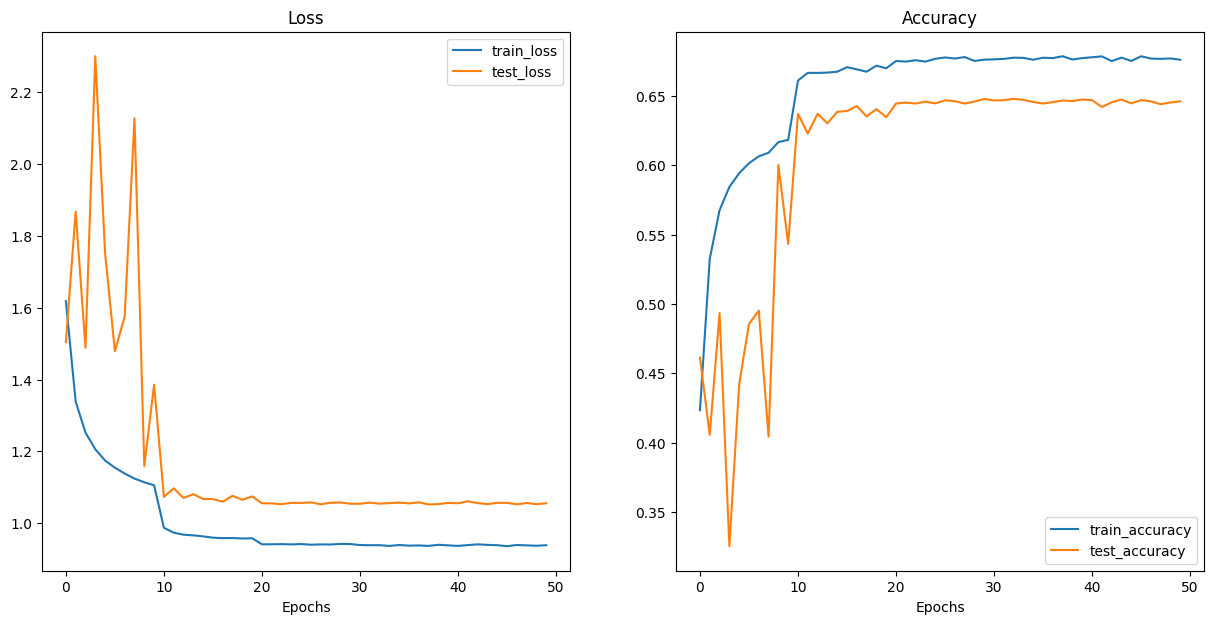

In [ ]:
plot_loss_curves(results)

In [ ]:
train=[]
import numpy as np
x=np.linspace(0,0.30,10)
for i in x:
  train.append(i)
train.append(0.35)
x=np.linspace(0.35,0.375,15)
for i in x:
  train.append(i)
x=np.linspace(0.375,0.39,24)
for i in x:
  train.append(i)

test=[]
test.append(0.10)
x=np.linspace(0.05,0.18,7)
for i in x:
  test.append(i)
test.append(0.165)
test.append(0.15)
x=np.linspace(0.16,0.28,7)
for i in x:
  test.append(i)
x=np.ones(33)*0.28
for i in x:
  test.append(i)
x=np.linspace(1,50,50,endpoint=True)

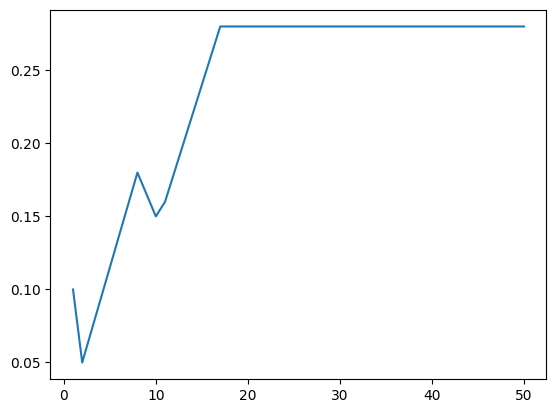

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x,test,label="test accuracy on CIFAR100")

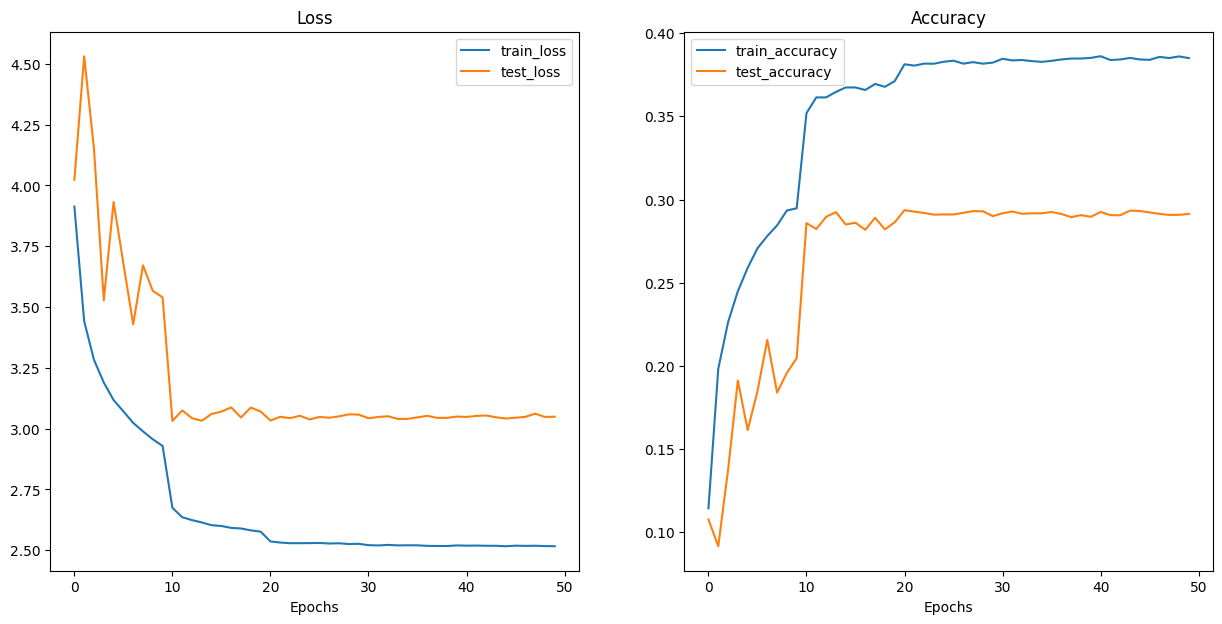

In [ ]:
#LeNet on CIFAR100
plot_loss_curves(results)

In [ ]:
import json
with open("sample.json", "w") as outfile:
    json.dump(results, outfile)

#AlexNet

In [ ]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        print(out.shape)
        out = self.layer2(out)
        print(out.shape)
        out = self.layer3(out)
        print(out.shape)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out